#### Business Understanding
Tässä projektissa koulutamme neuroverkon oppimaan ja ennustamaan kissojen ja koirien kuvia. Sen jälkeen testaamme kuinka hyvin neuroverkko pystyy ennustamaan kuvia. Tämä on tärkeää, koska neuroverkkoja voidaan käyttää moniin eri tarkoituksiin, kuten kuvien tunnistamiseen, joten on tärkeää tietää kuinka hyvin ne toimivat. Tämän jälkeen vertaamme mallin suorituskykyä VGG16-malliin, joka on yksi tunnetuimmista neuroverkoista kuvantunnistuksessa.

#### Data Understanding
Neuroverkko koulutetaan kuvilla, jotka sisältävät kissoja ja koiria. Kuvat ovat ladattu keggle.com sivustolta. Kuvia on yhteensä 25000, joista 12500 on kissoja ja 12500 koiria. Kuvat on jaettu kahteen kansioon, joista toinen sisältää kissojen kuvia ja toinen koirien kuvia. Kuvat ovat eri kokoisia ja eri muotoisia. Kuvat on ladattu jpg-muodossa.

In [39]:
import os, shutil, pathlib
os.environ["KERAS_BACKEND"] = "torch"

original_dir = pathlib.Path("train")                           
new_base_dir = pathlib.Path("cats_vs_dogs_small")              

def make_subset(subset_name, start_index, end_index):          
    for category in ("cat", "dog"):
        dir = new_base_dir / subset_name / category
        os.makedirs(dir)
        fnames = [f"{category}.{i}.jpg" 
                  for i in range(start_index, end_index)]
        for fname in fnames:
            shutil.copyfile(src=original_dir / fname,
                            dst=dir / fname)
  
make_subset("train", start_index=0, end_index=1000)            
make_subset("validation", start_index=1000, end_index=1500)    
make_subset("test", start_index=1500, end_index=2500)

#### Data Preparation

Kuvat koirista ja kissoista jaetaan train, validation ja test kansioihin. Kuvia on yhteensä 2500, joista 1000 on train, 500 validation ja 1000 test. Kuvien rgb-arvot skaalataan 1 ja 0 välille.

In [10]:
from tensorflow import keras 
from tensorflow.keras import layers
  
inputs = keras.Input(shape=(180, 180, 3))                            
x = layers.Rescaling(1./255)(inputs)                                 
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [11]:
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])


In [12]:
from tensorflow.keras.utils import image_dataset_from_directory
  
train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.
Found 2000 files belonging to 2 classes.


In [13]:
import numpy as np 
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [14]:
 batched_dataset = dataset.batch(32)
 for i, element in enumerate(batched_dataset):
     print(element.shape)
     if i >= 2:
         break


(32, 16)
(32, 16)
(32, 16)


In [15]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
     print(element.shape)
     if i >= 2:
         break

(4, 4)
(4, 4)
(4, 4)


#### Modeling
Neuroverkko koostuu kolmesta konvoluutio-kerroksesta, kolmesta maxpooling-kerroksesta ja kolmesta täysin yhdistetystä kerroksesta. Neuroverkko käyttää relu-aktivaatiofunktiota ja softmax-aktivaatiofunktiota. Neuroverkko koulutetaan 12 epookilla ja 32 erän kokoisilla erillä. Neuroverkon suorituskykyä verrataan VGG16-malliin.

In [16]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=12,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/12
63/63 ━━━━━━━━━━━━━━━━━━━━ 52s 769ms/step - accuracy: 0.5147 - loss: 0.7185 - val_accuracy: 0.5000 - val_loss: 0.7015
Epoch 2/12
63/63 ━━━━━━━━━━━━━━━━━━━━ 50s 794ms/step - accuracy: 0.5472 - loss: 0.6904 - val_accuracy: 0.5090 - val_loss: 0.6882
Epoch 3/12
63/63 ━━━━━━━━━━━━━━━━━━━━ 45s 719ms/step - accuracy: 0.5651 - loss: 0.6855 - val_accuracy: 0.6420 - val_loss: 0.6598
Epoch 4/12
63/63 ━━━━━━━━━━━━━━━━━━━━ 47s 736ms/step - accuracy: 0.6327 - loss: 0.6466 - val_accuracy: 0.6230 - val_loss: 0.6341
Epoch 5/12
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 683ms/step - accuracy: 0.6754 - loss: 0.5927 - val_accuracy: 0.6440 - val_loss: 0.6142
Epoch 6/12
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 703ms/step - accuracy: 0.6967 - loss: 0.5770 - val_accuracy: 0.6700 - val_loss: 0.5906
Epoch 7/12
63/63 ━━━━━━━━━━━━━━━━━━━━ 44s 698ms/step - accuracy: 0.7026 - loss: 0.5400 - val_accuracy: 0.7080 - val_loss: 0.5585
Epoch 8/12
63/63 ━━━━━━━━━━━━━━━━━━━━ 43s 692ms/step - accuracy: 0.7497 - loss: 0.5000 - val_accu

#### Evaluation

Malli toimii odotettua paremmin, sillä se ennustaa kuvia noin 85 % tarkkuudella.

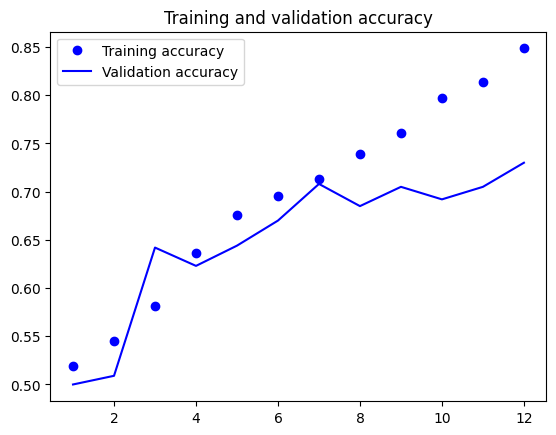

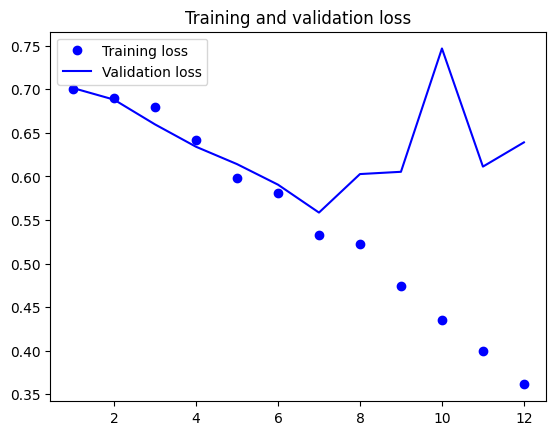

In [18]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [19]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


In [20]:
import numpy as np
  
def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)
  
train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 

In [26]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)               
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])
  
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=5,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step - accuracy: 0.8755 - loss: 35.3504 - val_accuracy: 0.9640 - val_loss: 5.5097
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9816 - loss: 2.4304 - val_accuracy: 0.9660 - val_loss: 7.0486
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step - accuracy: 0.9882 - loss: 1.5391 - val_accuracy: 0.9740 - val_loss: 3.2843
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9908 - loss: 0.9704 - val_accuracy: 0.9630 - val_loss: 7.1552
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9893 - loss: 1.0843 - val_accuracy: 0.9740 - val_loss: 4.7789


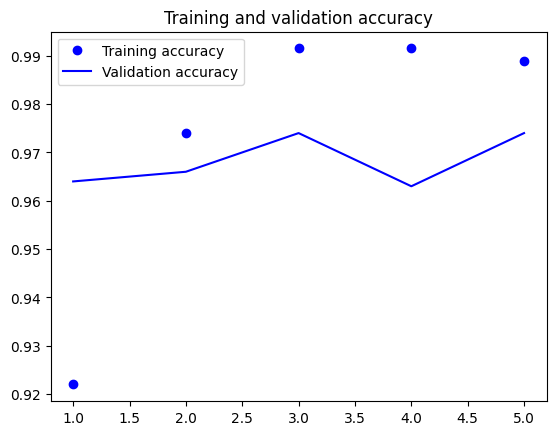

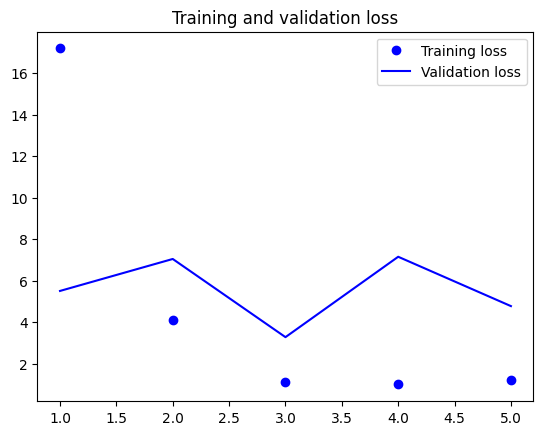

In [27]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [28]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

In [30]:
conv_base.trainable = True
print("This is the number of trainable weights " 
          "before freezing the conv base:", len(conv_base.trainable_weights))

conv_base.trainable = False
print("This is the number of trainable weights " 
          "after freezing the conv base:", len(conv_base.trainable_weights))

This is the number of trainable weights before freezing the conv base: 26
This is the number of trainable weights after freezing the conv base: 0


In [32]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)
  
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = keras.Model(inputs, outputs)
model.compile(loss="binary_crossentropy",
              optimizer="rmsprop",
              metrics=["accuracy"])

In [34]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=5,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 188s 3s/step - accuracy: 0.9432 - loss: 6.2681 - val_accuracy: 0.9810 - val_loss: 2.6186
Epoch 2/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 193s 3s/step - accuracy: 0.9571 - loss: 5.1081 - val_accuracy: 0.9690 - val_loss: 4.4574
Epoch 3/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 184s 3s/step - accuracy: 0.9526 - loss: 6.7636 - val_accuracy: 0.9760 - val_loss: 3.0902
Epoch 4/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 183s 3s/step - accuracy: 0.9630 - loss: 4.3315 - val_accuracy: 0.9770 - val_loss: 2.5807
Epoch 5/5
63/63 ━━━━━━━━━━━━━━━━━━━━ 197s 3s/step - accuracy: 0.9659 - loss: 4.7754 - val_accuracy: 0.9760 - val_loss: 3.8082


In [35]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc:.3f}")

63/63 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.9743 - loss: 3.6544
Test accuracy: 0.976


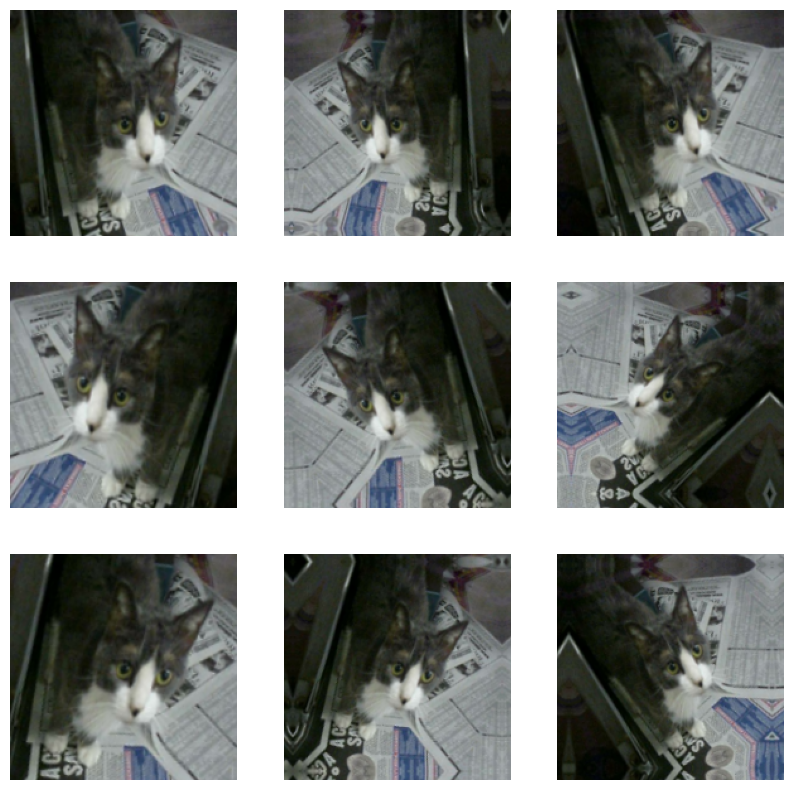

In [36]:
plt.figure(figsize=(10, 10)) 
for images, _ in train_dataset.take(1):                           
    for i in range(9):
        augmented_images = data_augmentation(images)              
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))   
        plt.axis("off")

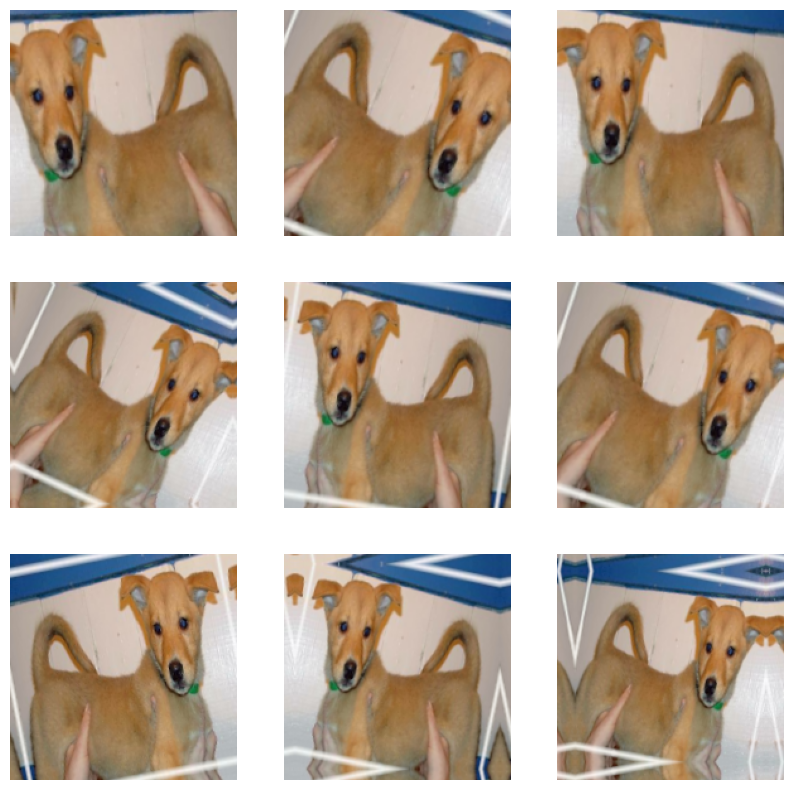

In [41]:
plt.figure(figsize=(10, 10)) 
for images, _ in train_dataset.take(2):                           
    for i in range(9):
        augmented_images = data_augmentation(images)              
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))   
        plt.axis("off")

#### Deployment
Tämän avulla neuroverkko voi päätellä onko kuvassa kissa vai koira ja sitä voidaan käyttää kuvien tunnistamiseen.

#### Kysymykset:
1. Miksi siirto-oppiminen auttaa?
- Siirto-oppiminen auttaa, koska malli pystyy oppimaan uusia asioita jo opituista asioista. Tämä nopeuttaa mallin kouluttamista ja parantaa mallin suorituskykyä.

2. Miten data-augmentaatio vaikuttaa tuloksiin?
- Data-augmentaatio parantaa mallin suorituskykyä, koska se luo uusia kuvia olemassa olevista kuvista. Tämä auttaa mallia oppimaan paremmin ja parantaa mallin suorituskykyä.

3. Mitkä olivat suurimmat haasteet?
- Mallin kouluttaminen on todella aikaavievää ja vaatii paljon laskentatehoa. Mallin kouluttaminen kestää noin 30 minuuttia. Mallin kouluttamisessa pitää myös olla varovainen mallin ylikouluttamisen suhteen.

4. Suorituskykyä voitaisiin parantaa huomattavasti vaihtamalla epokkien määrää ja erän kokoa, mutta tämä vaatisi paljon laskentatehoa ja aikaa. Lisäksi voisimme myös muokata learning ratea. Kolmas tapa olisi lisätä neuroverkkoon lisää kerroksia ja neuroneja ja viimeisenä asiana minkä voisimme tehdä on ostaa parempi näytönohjain.